In [1]:
from filtros import *
from functions import eta_subciclo
from functions import eta_subciclo_nominal
from fit_voc import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### Definimos los modelos a usar

In [2]:
param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    Qmax=4.850,
    # Qmax=df.SoH.max(),
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=300,
    adapt_cell=True
)

f_lineal = FiltrosAnidados()
f_lineal.Q_inst = param.get("Qmax")
f_lineal.fit_batt_model(param)
f_lineal.modelo_th.fit_inverse()
# Ajustamos los parámetros del estimaodor
f_lineal.voc_thresh = 0.05
f_lineal.voc_times = 47
f_lineal.sigma_autonomia = 0.04
f_lineal.sigma_capacidad = 0.001 * 5
f_lineal.estim_kwargs = {"sigma_e": 0.00075}

f_maxmin = FiltrosAnidados()
f_maxmin.Q_inst = param.get("Qmax")
f_maxmin.fit_batt_model(param)
f_maxmin.modelo_th.fit_inverse()
# Ajustamos los parámetros del estimaodor
f_maxmin.voc_thresh = 0.05
f_maxmin.voc_times = 47
f_maxmin.sigma_autonomia = 0.04
f_maxmin.sigma_capacidad = 0.001 * 5
f_maxmin.estim_kwargs = {"sigma_e": 0.00075}

f_subcnom = FiltrosAnidados()
f_subcnom.Q_inst = param.get("Qmax")
f_subcnom.fit_batt_model(param)
f_subcnom.modelo_th.fit_inverse()
# Ajustamos los parámetros del estimaodor
f_subcnom.voc_thresh = 0.05
f_subcnom.voc_times = 47
f_subcnom.sigma_autonomia = 0.04
f_subcnom.sigma_capacidad = 0.001 * 5
f_subcnom.estim_kwargs = {"sigma_e": 0.00075}

# f_subc = FiltrosAnidados()
# f_subc.Q_inst = param.get("Qmax")
# f_subc.fit_batt_model(param)
# f_subc.modelo_th.fit_inverse()
# # Ajustamos los parámetros del estimaodor
# f_subc.voc_thresh = 0.05
# f_subc.voc_times = 47
# f_subc.sigma_autonomia = 0.04
# f_subc.sigma_capacidad = 0.001 * 5
# f_subc.estim_kwargs = {"sigma_e": 0.00075}

modelo de degradación adaptado a nueva celda
Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.85,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0, 1.0, 1.0],
                      '100-25': [1.000003, 1.0000106400424538, 1.00000193],
                      '100-50': [0.999989, 0.9999681203811235, 0.9999942],
                      '100-75': [1.000027, 1.0000858427632289, 1.00001563],
                      '25-0': [1.000054, 1.0001673705038063, 1.00003047],
                      '50-0': [1.000037, 1.0001149649560208, 1.00002093],
                      '50-25': [1.000043, 1.0001338867215952, 1.00002438],
                      '62.5-37.5': [1.000008, 1.0000248002306413, 1.00000451],
     

### Obtenemos el Ground Truth

In [3]:
# Obtenemos el ground truth
gt_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset Stanford/W10/W10_diagnostics.csv"
gt_path_values = pd.read_csv(gt_path,header=None)
gt_path_values = gt_path_values.values

path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
files.remove('C7.csv')

# Combine files and soh values into a df
data_values = [[file, SOH] for file, SOH in zip(files, gt_path_values[1:])]
column_names = ['file', 'SOH']
gt_df = pd.DataFrame(data_values, columns=column_names)

In [4]:
def eta_subciclo(extremos, modelo):
    ind = 0
    eta = 1
    while ind < len(extremos):
        subciclo=[extremos[ind],extremos[ind+1]]
        eta_k = modelo.get_factor(subciclo,True)
        print("calculo para subciclo: ",subciclo, "eta = ",eta_k)
        eta *= eta_k 
        ind += 2
    return eta

def eta_subciclo_nominal(extremos, modelo):
    ind = 0
    eta = 1
    while ind < len(extremos):
        subciclo=[extremos[ind],extremos[ind+1]]
        eta_k = modelo.get_factor(subciclo,False) # False usa eta nominal
        print("calculo para subciclo nominal: ",subciclo," eta = ",eta_k)
        eta *= eta_k 
        ind += 2
    return eta

### Ejecutamos el modelo de degradación

In [5]:
## Actualizamos la capacidad máxima de cada modelo
f_lineal.Q_inst = param.get("Qmax")
f_maxmin.Q_inst = param.get("Qmax")
# f_subc.Q_inst = param.get("Qmax")
f_subcnom.Q_inst = param.get("Qmax")

## Iniciamos las configuraciones para el proceso de filtrado
path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
files.remove('C7.csv')
print(files)

## Iniciamos las variables del modelo

## Variables globales
Q_healthy = param.get("Qmax")

## Variables método maxmin
file_path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10', 'C1.csv')
df = pd.read_csv(file_path,usecols=["step_ind","SoC"])
dsoc_maxmin = 0
soc_acc = 0
soc_inst_maxmin = df.SoC.values[0]*100
soc_counting_maxmin = [soc_inst_maxmin]  # Initialize soc_counting list
step_counting_maxmin = [df.step_ind.values[0]]  # Initialize soc_counting list
maxmin_SoH_values = []

## Variables método subciclo nominal
dsoc_subc = 0
dsoc_subcnom = 0
soc_inst_subc = df.SoC.values[0]*100
soc_inst_subcnom = df.SoC.values[0]*100

extremos_subc = []
extremos_subcnom = []
subc_SoH_values = []
subcnom_SoH_values = []

## Variables método lineal
lineal_soc_counting = [100,20]
lineal_eta_k = f_lineal.get_factor(lineal_soc_counting,False) # generamos el eta
lineal_SoH_values = [1]  # Initialize knn_SoH_values list

## Variables GT
gt_idx = 0
gt_soh_values = [gt_path_values[0][0]]  # Initialize knn_SoH_values list
gt_soh_idx = [gt_idx]

# Iterating through all the datasets
for file in files:
    if not file.endswith(".csv"):
        continue  # Skip files that are not CSV

    file_path = os.path.join(path, file)
    columns_to_select = ["step_ind","current","time","exp"]
    df = pd.read_csv(file_path,usecols=columns_to_select)

    gt_soh_value = gt_df.SOH.values[files.index(file)][0]
    gt_soh_values.append(gt_soh_value)
    gt_idx += round(len(df.current.values)/100)
    gt_soh_idx.append(gt_idx)

    for cnt, exp in enumerate(df.exp.unique()):
        print(file, cnt, end="\r")
        df_ = df[df.exp == exp]
        # Aplicamos eta al metodo lineal
        f_lineal.Q_inst *= lineal_eta_k[0]  # Update f_gt.Q_inst

        # Iterate over the rows in the filtered DataFrame
        for ind, (c, dt, step,step_) in enumerate(zip(df_.current.values,
                                                    df_.time.values[1:] - df_.time.values[:-1],
                                                    df_.step_ind.values,
                                                    df_.step_ind.values[1:])):
            dsoc_maxmin = dt * c / (f_maxmin.Q_inst * 36)
            # dsoc_subc = dt * c / (f_subc.Q_inst * 36)
            dsoc_subcnom = dt * c / (f_subcnom.Q_inst * 36)

            soc_inst_maxmin += dsoc_maxmin
            soc_inst_subc += dsoc_subc
            soc_inst_subcnom += dsoc_subcnom

            if soc_inst_maxmin >= 100:
                soc_inst_maxmin = 100
                soc_counting_maxmin.append(soc_inst_maxmin)
            elif soc_inst_maxmin < 0:
                soc_inst_maxmin = 0
                soc_counting_maxmin.append(soc_inst_maxmin)
            else:
                soc_counting_maxmin.append(soc_inst_maxmin)

            if soc_inst_subc >= 100:
                soc_inst_subc = 100
            elif soc_inst_subc < 0:
                soc_inst_subc = 0

            if soc_inst_subcnom >= 100:
                soc_inst_subcnom = 100
            elif soc_inst_subcnom < 0:
                soc_inst_subcnom = 0
            
            ## implementación metodo maxmin
            if dsoc_maxmin < 0:
                soc_acc += dsoc_maxmin
            if -100 >= soc_acc:
                eta_k_maxmin = f_maxmin.get_factor(soc_counting_maxmin,False)
                f_maxmin.Q_inst *= eta_k_maxmin[0]

                soc_acc = 0
                soc_counting_maxmin = []

            ## implementación metodos subciclo
            # Detección de minimo
            if ((step in [13, 14]) and (step_ not in [13, 14])):  
                extremos_subc.append(soc_inst_subc)
                extremos_subcnom.append(soc_inst_subcnom)
            # Detección de máximo
            elif ((step not in [13, 14]) and (step_ in [13, 14])):  
                extremos_subc.append(soc_inst_subc)
                extremos_subcnom.append(soc_inst_subcnom)

            if len(extremos_subc) == 2:
                ## actualizamos capacidad subciclo modificado
                # eta_k_subc = eta_subciclo(extremos_subc, f_subc)
                # f_subc.Q_inst *= eta_k_subc[0]
                ## actualizamos capacidad subciclo nominal
                eta_k_subc_nom = eta_subciclo_nominal(extremos_subcnom, f_subcnom)
                f_subcnom.Q_inst *= eta_k_subc_nom[0]

                extremos_subc = []
                extremos_subcnom = []

            # actualización de SoH por método
            lineal_SoH_values.append(f_lineal.Q_inst / Q_healthy)  # Append SoH value to knn_SoH_values 
            maxmin_SoH_values.append(f_maxmin.Q_inst / Q_healthy)  # Append SoH value to knn_SoH_values
            subcnom_SoH_values.append(f_subcnom.Q_inst / Q_healthy)  # Append SoH value to knn_SoH_values
            # subc_SoH_values.append(f_subc.Q_inst / Q_healthy)  # Append SoH value to knn_SoH_values

['C1.csv', 'C2.csv', 'C3.csv', 'C4.csv', 'C5.csv', 'C6.csv', 'C8.csv', 'C9.csv', 'C10.csv', 'C11.csv', 'C12.csv', 'C13.csv', 'C14.csv']
calculo para subciclo nominal:  [100, 20.008513221372144]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.948985101875]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.88890255704187]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.82865604718172]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.774678118087635]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.70906607228763]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.652417839809537]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.595976618439508]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.53057506672895]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.471545629842133]  eta =  [0.99926165]
calculo para subciclo nominal:  [100, 19.413232425525347]  eta =  [0.99926165]
ca

### Graficamos los resultados

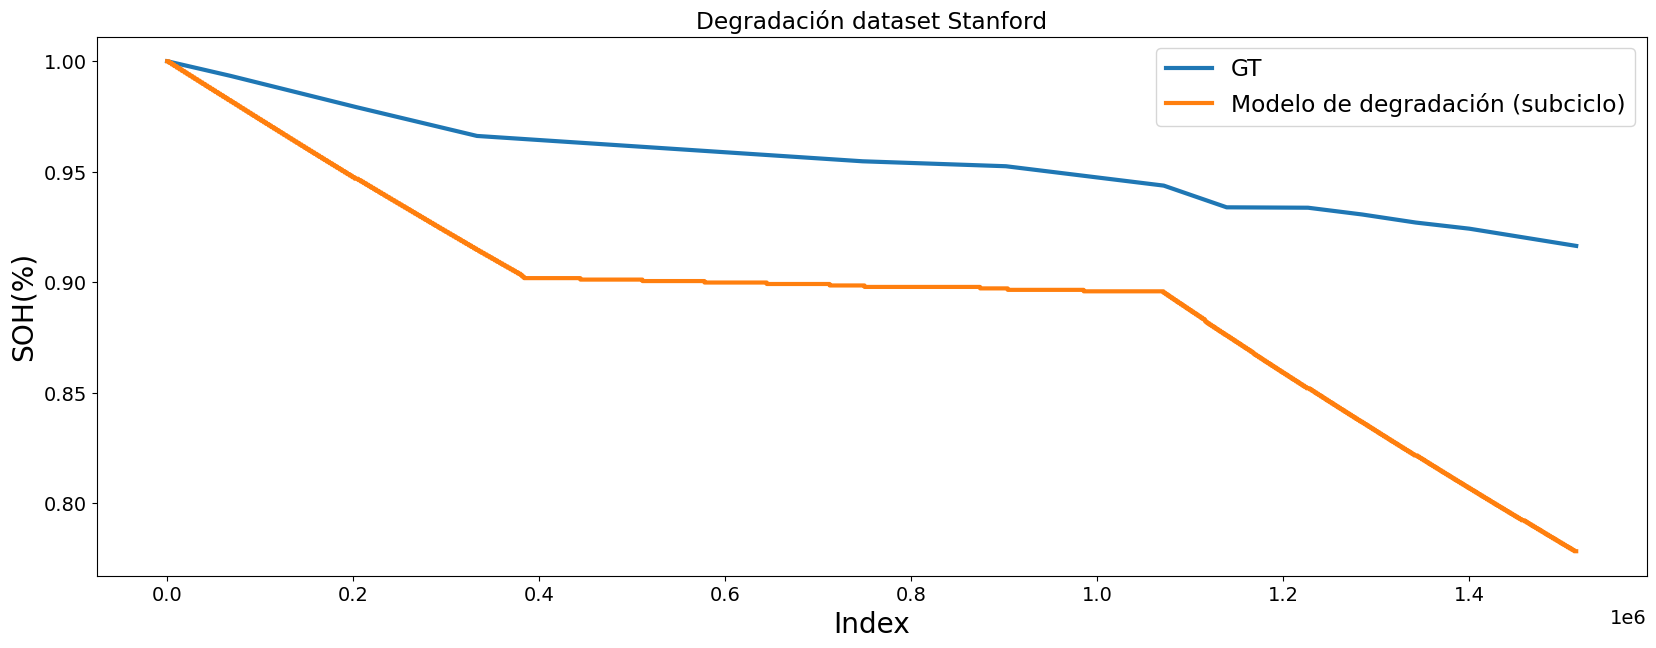

In [10]:
# lineal = lineal_SoH_values[::100]
# maxmin = maxmin_SoH_values[::100]
# subcnom = subcnom_SoH_values[::100]
# # subc = subc_SoH_values[::100]

plt.figure(figsize=(20, 7))

plt.plot(gt_soh_idx,gt_soh_values, label="GT")
# plt.plot(lineal, label='Metodo lineal')
# plt.plot(maxmin, label='Metodo maxmin')
plt.plot(subcnom, label='Modelo de degradación (subciclo)')

plt.title("Degradación dataset Stanford")
plt.xlabel("Index")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()